<h4>Identifying Individuals Based Off Of Their Accelerometer Data Using The WISDM Data Set</h4>


In [1]:
import numpy as np
import pandas as pd

In [2]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']

# save this for making a new data set if need be
# load in data set
df = pd.read_csv('WISDM_at_v2.0_raw.txt', header = None, names = columns)

# get rid of unnecessary characters
df['z-axis'] = df['z-axis'].str.rstrip(';')

# obtain only walking data since this has the most of any activity
walking = df.loc[df.activity == 'Walking']

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# unique id's before getting rid of those without a sufficient amount of data
walking.user.unique()

array([1679,  599,  685,  669, 1277,  674,  594,  678,  648,  584,  582,
        636, 1758,  708,  711,  687,  563,  621,  623,  720, 1793,  568,
        640,  671,  694,  664,  585,  684, 1480,  655, 1603,  651,  579,
        613,  590,  639,  587,  719,  635, 1742,  624,  710,  676,  693,
        646,  713,  610,  615,  705,  653,  702,  604,  618,  654,  656,
        606,  998,  586, 1319,  668, 1768, 1100,  573, 1491,  712, 1518,
        730,  622,  647, 1727, 1477,  588,  634,  661,  686,  690,  709,
        663,  597, 1656,  630,  616,  691,  625,  612,  650,  658, 1750,
        598,  729,  714,  607,  628,  589,  728,  925,  593,  600,  637,
        641,  609,  633, 1783,  688,  605, 1247,  695,  595,  602,  194,
        583,  716,  727, 1797, 1320, 1676,  673, 1802,  611, 1117,  689,
       1774,  666,  617,  706,  627,  675, 1799, 1703,  670, 1759, 1554,
       1778, 1064, 1238,  726,  632,  608,  725,  614,  697, 1775,  592,
        723,  591, 1512, 1253,  580,  703,  722,  6

In [4]:
# obtain only users who have over ~15 minutes of data
for i in walking.user.unique():    
    if len(walking[walking.user == i]) < 19000:
        walking = walking[walking.user != i]

In [5]:
# There are 7 unique users
walking.user.unique()

array([ 585, 1750,  688,  675, 1238,  603,  679])

In [6]:
# get rid of unnecessary characters and rows with empty entries
walking = walking[walking.columns.unique()].replace(';', '')
walking = walking.dropna()

# update columns to be usable types
walking.timestamp = walking.timestamp.astype(int)
walking['x-axis'] = walking['x-axis'].astype(float)
walking['y-axis'] = walking['y-axis'].astype(float)
walking['z-axis'] = walking['z-axis'].astype(float)


In [7]:
# function to normalize time stamps starting at 0 milliseconds
def normalize_time_stamps(df):

    # iterate through all users
    for user in df.user.unique():

        # iterate through all activities
        for activity in df.activity.unique():

            key = (df.user == user) & (df.activity == activity)
            # obtain all rows for a particular user and an activity
            user_activity_to_process = df[key]
            
            # if there are no rows for this activity, drop the activity from that user
            if len(user_activity_to_process.timestamp) == 0:
                df[(df.user == user)] = df[(df.user == user) & (df.activity != activity)]
                break

            # otherwise normalize the time stamps to start at 0, and be in milliseconds?
            else:
                df.loc[key, 'timestamp'] -= user_activity_to_process.timestamp.iloc[0]
                df.loc[key, 'timestamp'] /= 1000
                print(df[key])
                            
    return df

In [8]:
# obtain a data set with normalized time stamps
# this doesn't really matter for actual training, but it's nice to have clean timestamps
walking_norm = normalize_time_stamps(walking)
for user in walking_norm.user.unique():
    print(walking_norm.loc[walking_norm.user == user, 'timestamp'])

        user activity  timestamp    x-axis    y-axis     z-axis
316949   585  Walking       0.00  3.173541 -0.694638   9.152874
316950   585  Walking       0.05  3.146300 -0.340509   9.193735
316951   585  Walking       0.10  1.184970 -0.040861  10.841797
316952   585  Walking       0.15  2.792171  0.653777  10.310603
316953   585  Walking       0.20  2.220117  0.503953  10.106298
...      ...      ...        ...       ...       ...        ...
342233   585  Walking    1333.50 -0.463092  5.706926   8.349273
342234   585  Walking    1333.55 -1.607201  5.516241   8.621680
342235   585  Walking    1333.60 -1.307553  5.625204   8.539958
342236   585  Walking    1333.65 -1.334794  5.788648   9.003050
342237   585  Walking    1333.70 -1.225831  6.020194   8.471856

[21886 rows x 6 columns]
         user activity  timestamp    x-axis     y-axis     z-axis
1492383  1750  Walking      0.000 -3.823853  12.672226   0.331696
1492384  1750  Walking      0.050  4.261078   4.433762  10.710114
1492385 

In [9]:
from sklearn.preprocessing import StandardScaler

# scale x,y,z axes
scaler = StandardScaler()
walking_norm[['x-axis', 'y-axis', 'z-axis']] = scaler.fit_transform(walking_norm[['x-axis', 'y-axis', 'z-axis']].to_numpy())

In [21]:
# utilize 2 second windows with 50% overlap 
new_features = []
labels = []

# 20 HZ sampling means 20 samples every second. Therefore 2 seconds is 40 samples, .
step_size = 20
window_size = 40

for user in walking_norm.user.unique():
    user_walking_data = walking_norm[walking_norm.user == user]

    # go through each users walking data and transform it into 
    for window_start in range(0, len(user_walking_data) - window_size, step_size):
        x = user_walking_data['x-axis'].values[window_start: window_start + window_size]
        y = user_walking_data['y-axis'].values[window_start: window_start + window_size]
        z = user_walking_data['z-axis'].values[window_start: window_start + window_size]
        new_features.append([x, y, z])

        # label for a data window is just the user
        labels.append(user)

# Convert to numpy
new_features = np.asarray(new_features, dtype=np.float32).transpose(0, 2, 1)

In [60]:
# perform preprocessing 
from scipy.signal import find_peaks, peak_widths
from numpy import linalg as LA


def preprocess_xyz(features, labels):
    
    # array to hold new vector
    processed_features = []
    
    # columns for each new feature that's derived from x,y,z accelerometer data
    new_columns = [
               'x_mean', 'y_mean', 'z_mean', 
               'x_median', 'y_median', 'z_median', 
               'magnitude',
               'xz_cor', 'yz_cor',
               'x_peaks', 'y_peaks', 'z_peaks', 'avg_peaks',
               'x_peak_width_mean', 'y_peak_width_mean', 'z_peak_width_mean'
              ]
    for row in features:
        
        # obtain x,y,z axes data for particular window
        x = row[:,0]
        y = row[:,1]
        z = row[:,2]
        
        # find the peaks of height greater than 0.5 for x,y,z axes
        x_peaks, _ = find_peaks(x, height=0.1)
        y_peaks, _ = find_peaks(y, height=0.1)
        z_peaks, _ = find_peaks(z, height=0.1)
        
        # obtain average width of peaks from base for x,y,z axes
        x_peak_widths = peak_widths(x, x_peaks, rel_height=0)
        y_peak_widths = peak_widths(y, y_peaks, rel_height=0)
        z_peak_widths = peak_widths(z, z_peaks, rel_height=0)
        
        # 16 time domain features per row 
        # we may want to include these same features for the frequency domain
        new_row = [
                   np.average(x), np.average(y), np.average(z),
                   np.median(x),  np.median(y),  np.median(z),
                   LA.norm(row),
                   np.average(x)/np.average(z), np.average(y)/np.average(z),
                   len(x_peaks), len(y_peaks), len(z_peaks), len(x_peaks)+len(y_peaks)+len(z_peaks)/3,
                   np.average(x_peak_widths), np.average(y_peak_widths), np.average(z_peak_widths)
                   ]
        
        # append the new feature row to the data set
        processed_features.append(new_row)

        
    # create dataframe so we can see what's going on in the data
    processed_data = pd.DataFrame(processed_features, columns=new_columns)

    # append column of users
    processed_data['user'] = labels
    
    return processed_data


In [98]:
# process our data
feature_vector = preprocess_xyz(new_features, labels)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:33: PeakPropertyWarning: some peaks have a width of 0
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: PeakPropertyWarning: some peaks have a width of 0
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:35: PeakPropertyWarning: some peaks have a width of 0


In [103]:
# this shows that there are some data points that are homogenous where no movement took
# place within the two seconds. Maybe widening the window makes sense then? If not ...
feature_vector = feature_vector.dropna(axis='rows')

In [104]:
feature_vector

,x_mean,y_mean,z_mean,x_median,y_median,z_median,magnitude,xz_cor,yz_cor,x_peaks,y_peaks,z_peaks,avg_peaks,x_peak_width_mean,y_peak_width_mean,z_peak_width_mean,user
0,0.946990,0.185893,1.065598,1.158928,0.120059,0.919775,11.609760,0.888694,0.174449,10,7,7,19.333333,10.400560,13.131824,12.063192,585
1,0.366839,0.635225,0.176146,0.131353,0.686723,0.132228,7.590978,2.082582,3.606237,8,12,9,23.000000,6.475202,9.534724,8.438801,585
2,-0.243062,0.845441,0.094488,-0.134399,0.879132,0.002707,7.168393,-2.572402,8.947568,4,12,6,18.000000,13.980551,10.748320,8.941076,585
3,-0.172490,0.898146,0.266439,-0.116682,0.957605,0.047370,7.939472,-0.647392,3.370931,6,9,10,18.333333,10.429657,8.942399,10.937046,585
4,-0.179282,0.891657,0.336782,-0.183120,0.922141,0.123296,8.095704,-0.532337,2.647580,7,9,11,19.666667,10.381932,11.969743,9.077658,585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8690,-1.608903,0.949615,0.170309,-1.511779,1.067475,0.026904,15.860342,-9.446944,5.575825,1,9,7,12.333333,5.595749,10.986391,10.337212,679
8692,-1.399155,0.855410,-0.146888,-1.445657,0.849759,-0.260564,13.522972,9.525287,-5.823532,1,8,5,10.666667,14.083283,10.020809,11.780324,679
8693,-1.372164,0.808598,-0.126558,-1.237536,0.762784,-0.161098,13.176128,10.842170,-6.389146,1,8,6,11.000000,4.083283,9.835559,10.045914,679
8694,-1.408098,0.859426,-0.023868,-1.530207,0.897956,-0.038678,13.342424,58.995792,-36.007816,1,8,6,11.000000,14.049680,9.915821,10.818047,679


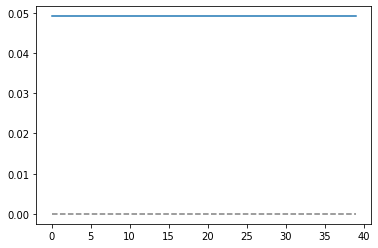

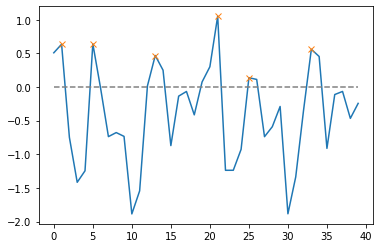

In [105]:
# example of there being no movement in a window
import matplotlib.pyplot as plt
row = new_features[-100]
x = row[:,0]
peaks, _ = find_peaks(x, height=0.0)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

# an example where there is movement in a window
row = new_features[1500]
x = row[:,0]
peaks, _ = find_peaks(x, height=0.0)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [106]:
''' 
Then it's clear that there are some useless data points in this set because 
there is no movement. So we'll get rid of it.
'''
useful_feature_vector = feature_vector[feature_vector['avg_peaks'] != 0]

# now our training set and labels are ready to be used
X = useful_feature_vector.drop(columns=['user']).to_numpy()
y = useful_feature_vector['user'].to_numpy()

<h4>Prepare Models</h4>

In [123]:
# first let's try a RF (Random Forest)

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

def random_forest(X_train, y_train, X_test, y_test, metrics=False):
    rfc = RandomForestClassifier(n_jobs=2, random_state=0)
    rfc.fit(X_train, y_train)
    preds = rfc.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    
    if metrics:
        print(pd.crosstab(y_test, preds, rownames=['Actual User'], colnames=['Predicted User']))
        print("Accuracy For Random Forest Is: " + str(accuracy))
        
    return accuracy

In [124]:
# quickly test random forest
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
              X, y, test_size=0.33, random_state=42)

# looks like we're in business
random_forest(X_train, y_train, X_test, y_test)



/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.981000633312223

<b>K-Fold Cross Validation</b>

In [131]:
from sklearn.model_selection import KFold

number_of_splits = 10
total_accuracy = 0

# perform kfold cross validation
kf = KFold(n_splits=number_of_splits, random_state=None, shuffle=True)
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # train model
    
    # random forest
    accuracy = random_forest(X_train, y_train, X_test, y_test)
    # test model
    
    print("Accuracy: " + str(accuracy))
    total_accuracy += accuracy
    
print("Accuracy after kfold cross validation is: " + str(total_accuracy/number_of_splits))

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.9812108559498957


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.9791231732776617


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.9853556485355649


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.9853556485355649


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.9916317991631799


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.9811715481171548


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.9937238493723849


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.9832635983263598


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.9790794979079498


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.9707112970711297
Accuracy after kfold cross validation is: 0.9830626916256847


In [125]:
import torch 
import torchvision
import os

import random
import math
import torch.utils.data as tdata
import torch.optim as opt
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [9, 6]

In [126]:
n_epochs = 20
batch_size_train = 64
batch_size_test = 512
learning_rate = 0.001
logging_interval = 1
valid_percent = 0.2